In [1]:
import os
import cv2
import random
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction import DictVectorizer

In [2]:
def load_and_shuffle_images_from_train_folder(train_folder):
    images = []
    for label in os.listdir(train_folder):
        label_folder = os.path.join(train_folder, label)
        if os.path.isdir(label_folder):
            for filename in os.listdir(label_folder):
                img_path = os.path.join(label_folder, filename)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Read images in grayscale
                if img is not None:
                    images.append(img)

    random.shuffle(images)
    return images

# Example usage:
train_folder = 'D:\\ML Project\\train'
train_images = load_and_shuffle_images_from_train_folder(train_folder)

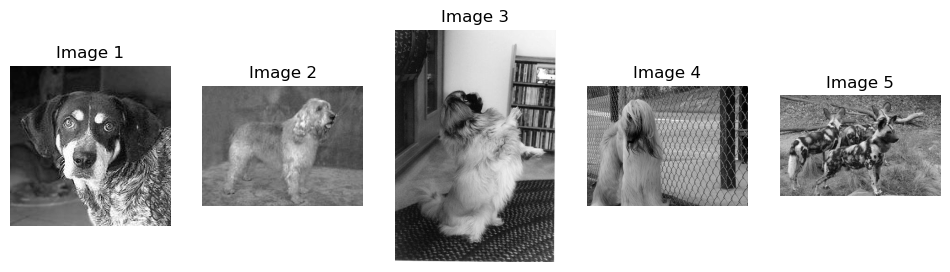

In [3]:
def visualize_images(images, num_images=5):
    plt.figure(figsize=(12, 6))
    for i in range(min(num_images, len(images))):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.axis('off')
        plt.title(f"Image {i + 1}")

    plt.show()
    
# Visualize the first five images
visualize_images(train_images[:5])

In [4]:
def preprocess_images_for_orb(images, target_size=(256, 256)):
    processed_images = []

    for img in images:
        # Resize image to the target size
        resized_img = cv2.resize(img, target_size)

        # Check if the image is in color
        if len(resized_img.shape) == 3:
            # Convert color image to grayscale
            grayscale_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2GRAY)
        else:
            # Image is already in grayscale
            grayscale_img = resized_img

        # Convert image to np.uint8 type
        processed_img = np.uint8(grayscale_img)
        processed_images.append(processed_img)

    return processed_images

preprocessed_train_images = preprocess_images_for_orb(train_images)

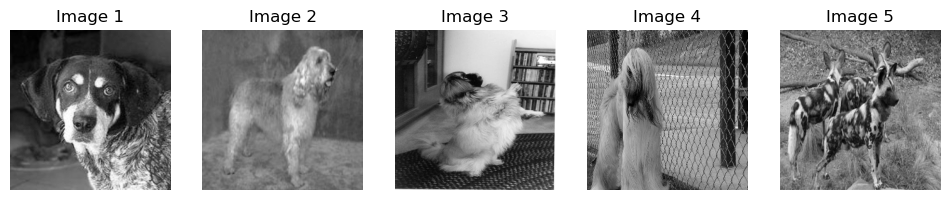

In [5]:
# Visualize the first five images
visualize_images(preprocessed_train_images[:5])

In [6]:
# Create an ORB object
orb = cv2.ORB_create()

# Initialize lists to store keypoints and descriptors
keypoints_list = []
descriptors_list = []

# Apply ORB feature extraction to each preprocessed image
for img in preprocessed_train_images:
    # Find keypoints and compute descriptors
    keypoints, descriptors = orb.detectAndCompute(img, None)

    # Store keypoints and descriptors
    keypoints_list.append(keypoints)
    descriptors_list.append(descriptors)


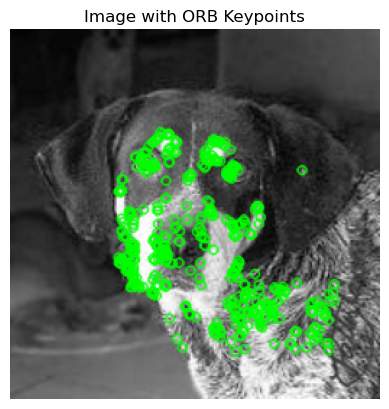

In [7]:
# Visualize keypoints on one of the images (optional)
sample_img_index = 0
sample_img = preprocessed_train_images[sample_img_index].copy()
sample_img = cv2.cvtColor(sample_img, cv2.COLOR_GRAY2BGR)
cv2.drawKeypoints(sample_img, keypoints_list[sample_img_index], sample_img, color=(0, 255, 0), flags=0)

# Display the image with keypoints
plt.imshow(sample_img)
plt.title("Image with ORB Keypoints")
plt.axis('off')
plt.show()

In [8]:
# Filter out None descriptors
filtered_descriptors_list = [descriptor for descriptor in descriptors_list if descriptor is not None]

# Check if there are any descriptors after filtering
if not filtered_descriptors_list:
    print("No descriptors found.")
else:
    # Flatten and pad the descriptors for k-means clustering
    max_descriptor_size = max(descriptor.shape[1] for descriptor in filtered_descriptors_list)
    padded_descriptors = [np.pad(descriptor, ((0, 0), (0, max_descriptor_size - descriptor.shape[1])), 'constant', constant_values=0) for descriptor in filtered_descriptors_list]
    flattened_descriptors = np.vstack(padded_descriptors)

    # Define the number of clusters (in this case, 5)
    num_clusters = 5

    # Apply k-means clustering
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(flattened_descriptors)

    # Get the cluster centers (visual words) from k-means
    visual_words = kmeans.cluster_centers_

# Create a bag-of-words representation
bag_of_words = []

for descriptors in descriptors_list:
    # Check if descriptors is not None or NaN
    if descriptors is not None and not np.isnan(descriptors).any():
        # Predict cluster assignments for each descriptor
        cluster_assignments = kmeans.predict(descriptors)

        # Create a histogram of cluster assignments
        histogram = {i: 0 for i in range(num_clusters)}
        for assignment in cluster_assignments:
            histogram[assignment] += 1

        bag_of_words.append(histogram)

# Convert the bag-of-words representation to a matrix
vec = DictVectorizer(sparse=False)
flattened_descriptors = vec.fit_transform(bag_of_words)

# Perform k-means clustering on the bag-of-words matrix
kmeans.fit(flattened_descriptors)

# Get the cluster centers (visual words) from k-means
visual_words = kmeans.cluster_centers_

C:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


C:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)
C:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1962: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


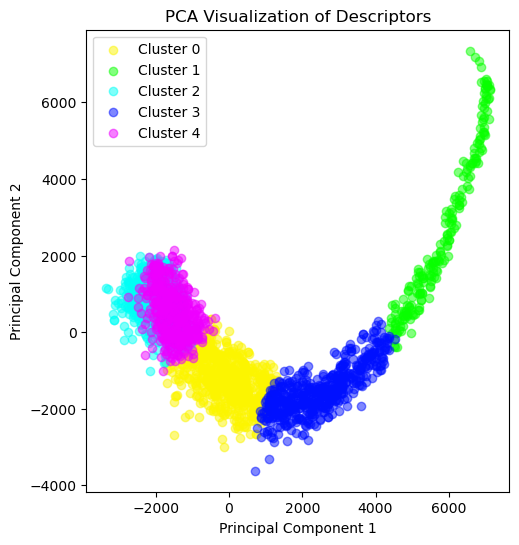

In [9]:
# Get the maximum descriptor size
max_descriptor_size = max(descriptor.shape[1] if descriptor is not None else 0 for descriptor in descriptors_list)

# Sample a fraction of descriptors
fraction = 0.5  # Adjust as needed
sampled_descriptors = random.sample(descriptors_list, int(fraction * len(descriptors_list)))

# Pad and flatten the descriptors for k-means clustering
padded_descriptors = []
for descriptor in sampled_descriptors:
    if descriptor is not None:
        padded_descriptor = np.pad(descriptor, ((0, 0), (0, max_descriptor_size - descriptor.shape[1])), 'constant', constant_values=0)
        flattened_descriptor = padded_descriptor.flatten()
        padded_descriptors.append(flattened_descriptor)

# Find the maximum size after padding and flattening
max_size = max(len(descriptor) for descriptor in padded_descriptors)

# Pad the descriptors to match the maximum size
padded_descriptors = [np.pad(descriptor, (0, max_size - len(descriptor)), 'constant', constant_values=0) for descriptor in padded_descriptors]

# Stack the padded and flattened descriptors
flattened_descriptors = np.vstack(padded_descriptors)

# Perform MiniBatchKMeans clustering on the flattened descriptors
num_clusters = 5
batch_size = 1000  # Adjust as needed
kmeans = MiniBatchKMeans(n_clusters=num_clusters, batch_size=batch_size, random_state=42)
kmeans.fit(flattened_descriptors)

# Get the cluster assignments for each descriptor
cluster_assignments = kmeans.predict(flattened_descriptors)

# Apply PCA to visualize the clusters
pca = PCA(n_components=2)
transformed_descriptors = pca.fit_transform(flattened_descriptors)

# Set up a color palette for each cluster
palette = sns.color_palette("hsv", n_colors=num_clusters)

# Visualize PCA
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
for i in range(num_clusters):
    plt.scatter(transformed_descriptors[cluster_assignments == i, 0],
                transformed_descriptors[cluster_assignments == i, 1],
                alpha=0.5, label=f'Cluster {i}', color=palette[i])
plt.title('PCA Visualization of Descriptors')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()

NameError: name 'cluster_indices' is not defined

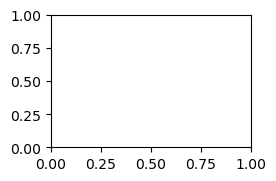

In [11]:
# Visualize any five images of each cluster
plt.figure(figsize=(15, 10))
for i in range(num_clusters):
    plt.subplot(num_clusters, 5, i * 5 + 1)
    if len(cluster_indices[i]) > 0:
        five_random_indices = np.random.choice(cluster_indices[i], size=min(5, len(cluster_indices[i])), replace=False)
        for j, img_index in enumerate(five_random_indices):
            plt.subplot(num_clusters, 5, i * 5 + j + 1)
            plt.imshow(preprocessed_train_images[img_index], cmap='gray')
            plt.axis('off')
            plt.title(f"Cluster {i}, Image {j + 1}")

plt.show()